In [1]:
#!pip install transformers
#!pip install pytorch-transformers

In [2]:
import numpy as np
import regex as re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
import math
import os

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

#import tensorflow as tf
#import tensorflow.keras.backend as K
import tokenizers
#from transformers import BertTokenizer, TFBertModel, BertForSequenceClassification, BertConfig

from transformers import BertTokenizer, BertModel, BertForSequenceClassification, BertConfig
import torch

from collections import Counter

import warnings
warnings.filterwarnings("ignore")

In [3]:
"""
# Detect hardware, return appropriate distribution strategy (you can see that it is pretty easy to set up).
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is set (always set in Kaggle)
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    print('Running on TPU ', tpu.master())
except ValueError:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print('Number of replicas:', strategy.num_replicas_in_sync)
"""

import torch

# Check if CUDA (GPU) is available
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f'Running on GPU: {torch.cuda.get_device_name(0)}')
else:
    device = torch.device('cpu')
    print('Running on CPU')

# Number of GPUs available
num_gpus = torch.cuda.device_count()
print('Number of GPUs:', num_gpus)

# If using multiple GPUs, use DataParallel or DistributedDataParallel
if num_gpus > 1:
    model = torch.nn.DataParallel(model)

Running on CPU
Number of GPUs: 0


In [4]:
"""
MODEL_NAME = 'bert-base-uncased'
MAX_LEN = 256
ARTIFACTS_PATH = '../artifacts/'

BATCH_SIZE = 8 * strategy.num_replicas_in_sync
EPOCHS = 3

if not os.path.exists(ARTIFACTS_PATH):
    os.makedirs(ARTIFACTS_PATH)
"""

import torch
import os

MODEL_NAME = 'bert-base-uncased'
MAX_LEN = 256
ARTIFACTS_PATH = '../../artifacts/'

# Determine the number of devices (GPUs/CPUs)
if torch.cuda.is_available():
    num_replicas = torch.cuda.device_count()
    print(f'Using {num_replicas} GPU(s)')
else:
    num_replicas = 1  # Use CPU or single GPU
    print('Using CPU')

# Set the batch size and number of epochs
BATCH_SIZE = 8 * num_replicas
EPOCHS = 3

# Create the artifacts directory if it doesn't exist
if not os.path.exists(ARTIFACTS_PATH):
    os.makedirs(ARTIFACTS_PATH)

print(f'Model: {MODEL_NAME}, Max Length: {MAX_LEN}, Batch Size: {BATCH_SIZE}, Epochs: {EPOCHS}')

Using CPU
Model: bert-base-uncased, Max Length: 256, Batch Size: 8, Epochs: 3


In [5]:
import pandas as pd
import re
import string

import nltk
from nltk.stem.wordnet import WordNetLemmatizer


from timeit import default_timer as timer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import model_selection, svm, metrics
from sklearn.metrics import accuracy_score, f1_score, fbeta_score, recall_score, precision_score, hamming_loss, jaccard_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.metrics import make_scorer
from sklearn.metrics import recall_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_20newsgroups

from pprint import pprint
import argparse

import re
import string

import cufflinks as cf
import plotly.offline as pyo
import plotly.graph_objs as go

import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import os
import pickle


from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize

import warnings
warnings.filterwarnings('ignore')

#
# we assume everything runs from bin directory
#
PICKLE_DIR = '../../pickles/'
OUT_DIR = '../../out/'
DATASET_DIR = '../../datasets/'


#dataset_available = {'reuters21578', '20newsgroups', 'ohsumed', 'rcv1'}
dataset_available = {'20newsgroups', 'bbc-news'}

In [7]:

#
# preprocessing utility methods
#

def create_confusion_matrix(y_test, y_pred, title, file_name=OUT_DIR+'svm_20newsgroups_confusion_matrix_best_model_table.png', debug=False):

    print("Creating confusion matrix...")

    # Assuming y_test and y_pred_best are already defined
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Plotting the confusion matrix as a table with numbers
    fig, ax = plt.subplots(figsize=(12, 8))  # Increase the width and height of the figure

    # Hide axes
    ax.xaxis.set_visible(False) 
    ax.yaxis.set_visible(False)
    ax.set_frame_on(False)

    # Create the table with smaller font sizes and adjusted scale
    table = ax.table(
        cellText=conf_matrix,
        rowLabels=[f'Actual {i}' for i in range(conf_matrix.shape[0])],
        colLabels=[f'Predicted {i}' for i in range(conf_matrix.shape[1])],
        cellLoc='center',
        loc='center'
    )

    # Adjust the font size and layout
    table.auto_set_font_size(False)
    table.set_fontsize(10)  # Reduced font size for better fitting
    table.scale(1.2, 1.2)

    # Add a title with centered text
    plt.title(title, fontsize=16, pad=20)

    # Adjust layout to add more padding around the plot
    plt.subplots_adjust(left=0.2, right=0.9, top=0.9, bottom=0.1)  # Increase padding on the left

    # Save the plot to a file
    confusion_matrix_filename = file_name
    plt.savefig(confusion_matrix_filename, bbox_inches='tight')  # Ensure everything is saved in the output file
    plt.show()

    print(f"Confusion matrix saved as {confusion_matrix_filename}")

    accuracy = accuracy_score(y_test, y_pred)

    # Plain text explanation of the confusion matrix
    if debug:
        print("\nHow to read this confusion matrix:")
        print("------------------------------------------------------")
        print("The confusion matrix shows the performance of the classification model.")
        print("Each row of the matrix represents the actual classes, while each column represents the predicted classes.")
        print("Values on the diagonal (from top-left to bottom-right) represent correct predictions (true positives and true negatives).")
        print("Values outside the diagonal represent incorrect predictions (false positives and false negatives).")
        print("\nAccuracy Score: {:.2f}%".format(accuracy * 100))
        
        print("\nConfusion Matrix Values:")
        for i in range(len(conf_matrix)):
            print(f"Actual class {i}:")
            for j in range(len(conf_matrix[i])):
                print(f"  Predicted as class {j}: {conf_matrix[i][j]}")

# --------------------------------------------------------------------------------------------------------------------------------------------



# --------------------------------------------------------------------------------------------------------------
#
# Utility functions for preprocessing data
#
# --------------------------------------------------------------------------------------------------------------
def missing_values(df):
    """
    Calculate the percentage of missing values for each column in a DataFrame.
    
    Args:
    df (pd.DataFrame): The input DataFrame to analyze.
    
    Returns:
    pd.DataFrame: A DataFrame containing the total count and percentage of missing values for each column.
    """
    # Calculate total missing values and their percentage
    total = df.isnull().sum()
    percent = (total / len(df) * 100)
    
    # Create a DataFrame with the results
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    
    # Sort the DataFrame by percentage of missing values (descending)
    missing_data = missing_data.sort_values('Percent', ascending=False)
    
    # Filter out columns with no missing values
    missing_data = missing_data[missing_data['Total'] > 0]
    
    print("Columns with missing values:")
    print(missing_data)
    
    return missing_data


def remove_punctuation(x):
    punctuationfree="".join([i for i in x if i not in string.punctuation])
    return punctuationfree


# Function to lemmatize text with memory optimization
def lemmatization(texts, chunk_size=1000):
    lmtzr = WordNetLemmatizer()
    
    num_chunks = len(texts) // chunk_size + 1
    #print(f"Number of chunks: {num_chunks}")
    for i in range(num_chunks):
        chunk = texts[i*chunk_size:(i+1)*chunk_size]
        texts[i*chunk_size:(i+1)*chunk_size] = [' '.join([lmtzr.lemmatize(word) for word in text.split()]) for text in chunk]
    
    return texts


def preprocessDataset(train_text):
    # Ensure input is string
    train_text = str(train_text)
    
    # Word tokenization using NLTK's word_tokenize
    tokenized_train_set = word_tokenize(train_text.lower())
    
    # Stop word removal
    stop_words = set(stopwords.words('english'))
    stopwordremove = [i for i in tokenized_train_set if i not in stop_words]
    
    # Join words into sentence
    stopwordremove_text = ' '.join(stopwordremove)
    
    # Remove numbers
    numberremove_text = ''.join(c for c in stopwordremove_text if not c.isdigit())
    
    # Stemming using NLTK's PorterStemmer
    stemmer = PorterStemmer()
    stem_input = word_tokenize(numberremove_text)
    stem_text = ' '.join([stemmer.stem(word) for word in stem_input])
    
    # Lemmatization using NLTK's WordNetLemmatizer
    lemmatizer = WordNetLemmatizer()
    
    def get_wordnet_pos(word):
        """Map POS tag to first character lemmatize() accepts"""
        tag = nltk.pos_tag([word])[0][1][0].upper()
        tag_dict = {"J": wordnet.ADJ,
                    "N": wordnet.NOUN,
                    "V": wordnet.VERB,
                    "R": wordnet.ADV}
        return tag_dict.get(tag, wordnet.NOUN)
    
    lem_input = word_tokenize(stem_text)
    lem_text = ' '.join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in lem_input])
    
    return lem_text


In [8]:

#
# load_data
#
def load_data(dataset='20newsgroups'):

    print(f"Loading data set {dataset}...")

    if (dataset == '20newsgroups'):
        
        print("Loading 20 newsgroups dataset...")

        # Fetch the 20 newsgroups dataset
        newsgroups = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))

        # Create a DataFrame from the Bunch object
        df = pd.DataFrame({
            'text': newsgroups.data,
            'category': newsgroups.target
        })

        # Add category names
        df['category_name'] = [newsgroups.target_names[i] for i in df['category']]

        print(f"Number of documents: {len(df)}")
        print(f"Number of categories: {len(df['category'].unique())}")
        print(f"Number of category names: {len(df['category_name'].unique())}")
        #pprint(list(df.target_names))
        #pprint(list(df.category_name))

        #df = df['category'].unique()    

        missing_values_df = missing_values(df)
        print(f"missing values:", missing_values_df)

        ### Start of Text Pre-processing
        print("preproccessing...")

        nltk.download('punkt')
        nltk.download('averaged_perceptron_tagger')
        nltk.download('wordnet')
        nltk.download('omw-1.4')

        string.punctuation

        ### 2. To LowerCase

        df['CleanedText'] = (df.text.apply(lambda x: x.lower()))

        ### 3. Removing Numbers and Special Characters including XXXXXX

        df['CleanedText'] =  (df.CleanedText.apply(lambda x: re.sub('\W+', ' ', x)))
        regex = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]')

        df['CleanedText'] =  (df.CleanedText.apply(lambda x: re.sub(regex, '', x)))
        df['CleanedText'] =  (df.CleanedText.apply(lambda x: re.sub('xxxx', '', x)))
        df['CleanedText'] =  (df.CleanedText.apply(lambda x: re.sub('xx', '', x)))

        print("removing punctuation...")

        df['CleanedText'] =  (df.CleanedText.apply(lambda x: remove_punctuation(x)))

        ### 5. Tokenization
        #data['TokenizedText'] =  (data.CleanedText.apply(lambda x: re.split('W+',x)))

        print("removing stopwords...")
        from nltk.corpus import stopwords
        nltk.download('stopwords')
        stopwords = set(stopwords.words("english"))
        df['CleanedText'] = df.CleanedText.apply(lambda x: " ".join(x for x in x.split() if x not in stopwords))
        print("Stopwords removed")
        #print(df['CleanedText'][0])

        ## TFIDF already tokenizes the text so no need to tokenize it here
        # from nltk.tokenize import sent_tokenize, word_tokenize
        # data2['TokenizedText'] = data2.CleanedText.apply(word_tokenize)


        ### 7. Text Normalization  [Lemmatization] -->better than Stemming since it returns actual words
        ## lemmatization is an intelligent operation that uses dictionaries

        print("Lemmatizing...")

        df['LemmatizedText'] = lemmatization(df['CleanedText'])

        print("Lemmatized")
        #print(df['CleanedText'][0])
        #print(df['LemmatizedText'][0])

        print("Tokenizing...")
        
        # Tokenize the text data
        df['tokenized'] = df['text'].str.lower().apply(nltk.word_tokenize)

        #return df, df['category'].unique()
        return df
    
    elif (dataset == 'bbc-news'):

        print("Loading BBC News dataset...")

        for dirname, _, filenames in os.walk(DATASET_DIR+'bbc-news'):
            for filename in filenames:
                print(os.path.join(dirname, filename))

        train_set = pd.read_csv(DATASET_DIR+'bbc-news/BBC News Train.csv')
        test_set = pd.read_csv(DATASET_DIR+'bbc-news/BBC News Test.csv')

        print("train_set:", train_set.shape)
        print(train_set.head())
        print("test_set:", test_set.shape)
        print(test_set.head())

        target_category = train_set['Category'].unique()
        print("target categories:", target_category)

        train_set['categoryId'] = train_set['Category'].factorize()[0]
        
        category = train_set[["Category","categoryId"]].drop_duplicates().sort_values('categoryId')
        print("after de-duping:", category)

        print(train_set.groupby('Category').categoryId.count())

        text = train_set["Text"] 
        print("text:\n", text.head())

        category = train_set["Category"]
        print("categories:\n", category.head())

        print("preprocessing...")
        train_set['Text'] = train_set['Text'].apply(preprocessDataset)
        text = train_set['Text']
        category = train_set['Category']
        print("text:\n", type(text), text.shape)
        print(text.head())

        #return text, category
        return train_set
    else:
        print(f"Dataset '{dataset}' not available.")
        return None

In [9]:
def run_svm_model(X_train, X_test, y_train, y_test, args):

    print("Training default Support Vector Machine model...")
    
    default_pipeline = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('lr', LinearSVC(max_iter=1000))
    ])

    default_pipeline.fit(X_train, y_train)
    y_pred_default = default_pipeline.predict(X_test)

    print("\nDefault Support Vector Mechine Model Performance:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred_default):.4f}")
    print(classification_report(y_true=y_test, y_pred=y_pred_default, digits=4))

    if (args.optimc):

        # Optimize Support Vector Machine with GridSearchCV
        print("Optimizing Support Vector Machine model with GridSearchCV...")

        # Define the pipeline
        pipeline = Pipeline([
            ('tfidf', TfidfVectorizer()),
            ('svm', LinearSVC(max_iter=1000))
        ])

        # Define the parameter grid
        param_grid = {
            'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],     # Unigrams, bigrams, or trigrams
            'tfidf__use_idf': [True, False],                    # Whether to use IDF
            'tfidf__sublinear_tf': [True, False],               # Sublinear term frequency
            'svm__penalty': ['l1', 'l2'],                       # Regularization method
            'svm__loss': ['hinge', 'squared_hinge'],            # Loss function
            'svm__multi_class': ['ovr', 'crammer_singer'],      # Multi-class strategy
            'svm__class_weight': [None, 'balanced'],            # Class weights
            'svm__C': np.logspace(-3, 3, 7)                     # Regularization parameter   
        }

        print("param_grid:", param_grid)

        cross_validation = StratifiedKFold()

        scorers = {
            'accuracy_score': make_scorer(accuracy_score),
            'f1_score': make_scorer(f1_score, average='micro'),
            'recall_score': make_scorer(recall_score, average='micro'),
            'precision_score': make_scorer(precision_score, average='micro'),
            'hamming_loss': make_scorer(hamming_loss),
            'jaccard_score': make_scorer(jaccard_score, average='micro')
            }

        grid_search = GridSearchCV(
            n_jobs=-1, 
            estimator=pipeline,
            refit='f1_score',
            param_grid=param_grid,
            cv=cross_validation,
            #scoring=scoring
            scoring=scorers,
            return_train_score=True         # ensure train scores are calculated
            )

        # Fit the model
        grid_search.fit(X_train, y_train)

        print('Best parameters: {}'.format(grid_search.best_params_))
        print("best_estimator:", grid_search.best_estimator_)
        print('Best score: {}'.format(grid_search.best_score_))
        print("cv_results_:", grid_search.cv_results_)

        results = grid_search.cv_results_

        if (args.plot):

            print("Plotting the results...")

            # Define the metrics we want to plot
            metrics_to_plot = ['accuracy_score', 'f1_score', 'recall_score', 'precision_score', 'hamming_loss']

            # Iterate over each metric to create a separate plot
            for metric in metrics_to_plot:
                traces = []

                print(f"Plotting {metric}...")

                for sample in ["train", "test"]:

                    key_mean = f"mean_{sample}_{metric}"
                    key_std = f"std_{sample}_{metric}"

                    print(f"Plotting {key_mean}...")
                    print(f"Plotting {key_std}...")

                    # Directly use the keys without conditional check
                    sample_score_mean = np.nan_to_num(np.array(results[key_mean]) * 100)  # Convert to percentage and handle NaN
                    sample_score_std = np.nan_to_num(np.array(results[key_std]) * 100)  # Convert to percentage and handle NaN

                    x_axis = np.linspace(0, 100, len(sample_score_mean))

                    # Create the trace for Plotly
                    traces.append(
                        go.Scatter(
                            x=x_axis,
                            y=sample_score_mean,
                            mode='lines+markers',
                            name=f"{metric} ({sample})",
                            line=dict(dash='dash' if sample == 'train' else 'solid'),
                            error_y=dict(
                                type='data',
                                array=sample_score_std,
                                visible=True
                            ),
                            hoverinfo='x+y+name'
                        )
                    )

                # Define the layout of the plot
                layout = go.Layout(
                    title={'text': f"Training and Test Scores for {metric.capitalize()}",
                        'y':0.9,
                        'x':0.5,
                        'xanchor': 'center',
                        'yanchor': 'top'},
                    xaxis=dict(title="Training Sample Percentage (%)"),
                    yaxis=dict(title="Score (%)", range=[0, 100]),
                    hovermode='closest'
                )

                # Create the figure
                fig = go.Figure(data=traces, layout=layout)

                # Write the plot to an HTML file
                filename = f'{OUT_DIR}training_test_scores_{metric}.html'
                pyo.plot(fig, filename=filename)

                print(f"Saved plot for {metric} as {filename}")

        # Extract the best estimator from the GridSearchCV
        best_model = grid_search.best_estimator_

        # Predict on the test set using the best model
        y_pred_best = best_model.predict(X_test)

        print("Accuracy best score:", metrics.accuracy_score(y_test, y_pred_best))
        print(classification_report(y_true=y_test, y_pred=y_pred_best, digits=4))


def run_lr_model(X_train, X_test, y_train, y_test, args):

    # Default Logistic Regression Model
    print("Training default Logistic Regression model...")
    default_pipeline = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('lr', LogisticRegression(max_iter=1000))
    ])

    default_pipeline.fit(X_train, y_train)
    y_pred_default = default_pipeline.predict(X_test)

    print("\nDefault Logistic Regression Model Performance:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred_default):.4f}")
    print(classification_report(y_true=y_test, y_pred=y_pred_default, digits=4))

    if (args.optimc):
        # Optimize Logistic Regression with GridSearchCV
        print("Optimizing Logistic Regression model with GridSearchCV...")

        # Define the pipeline
        pipeline = Pipeline([
            ('tfidf', TfidfVectorizer()),
            ('lr', LogisticRegression(max_iter=1000))
        ])

        # Define the parameter grid
        param_grid = {
            'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],     # Unigrams, bigrams, or trigrams
            'tfidf__use_idf': [True, False],                    # Whether to use IDF
            'tfidf__sublinear_tf': [True, False],               # Sublinear term frequency
            'lr__C': [0.01, 0.1, 1, 10, 100],                   # Inverse of regularization strength
            'lr__penalty': ['l2'],                              # Regularization method (L2 Ridge)
            'lr__solver': ['liblinear', 'lbfgs']                # Solver types
        }

        print("param_grid:", param_grid)

        # Define scorers
        scorers = {
            'accuracy_score': make_scorer(accuracy_score),
            'f1_score': make_scorer(f1_score, average='micro'),
            'recall_score': make_scorer(recall_score, average='micro'),
            'precision_score': make_scorer(precision_score, average='micro')
        }

        # Initialize GridSearchCV
        grid_search = GridSearchCV(
            estimator=pipeline,
            param_grid=param_grid,
            scoring=scorers,
            refit='f1_score',  # Optimize on F1 Score
            cv=StratifiedKFold(n_splits=5),
            n_jobs=-1,
            return_train_score=True
        )

        # Fit the model
        grid_search.fit(X_train, y_train)

        # Display the best parameters
        print('Best parameters found by GridSearchCV:')
        print(grid_search.best_params_)

        # Evaluate on the test set
        y_pred_optimized = grid_search.best_estimator_.predict(X_test)

        print("\nOptimized Logistic Regression Model Performance:")
        print(f"Accuracy: {accuracy_score(y_test, y_pred_optimized):.4f}")
        print(classification_report(y_true=y_test, y_pred=y_pred_optimized, digits=4))

    if (args.cm):
        # Optionally, plot confusion matrix for the optimized model
        create_confusion_matrix(
            y_test, 
            y_pred_optimized, 
            title='Confusion Matrix for Optimized Logistic Regression Model',
            file_name=OUT_DIR+'bbc_news_logistic_regression_confusion_matrix.png',
            debug=False
        )


def run_nb_model(X_train, X_test, y_train, y_test, args):

    print("Building default Naive Bayes Classifier...")

    nb = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('clf', MultinomialNB())
        ])
    
    nb.fit(X_train,y_train)

    test_predict = nb.predict(X_test)

    train_accuracy = round(nb.score(X_train,y_train)*100)
    test_accuracy =round(accuracy_score(test_predict, y_test)*100)

    print("Naive Bayes Train Accuracy Score : {}% ".format(train_accuracy ))
    print("Naive Bayes Test Accuracy Score  : {}% ".format(test_accuracy ))
    print(classification_report(y_true=test_predict, y_pred=y_test, digits=4))

    if (args.optimc):

        print("Optimizing the model using GridSearchCV...")

        # Define a pipeline
        pipeline = Pipeline([
            ('tfidf', TfidfVectorizer()),
            ('nb', MultinomialNB())
        ])

        # Define the parameter grid
        param_grid = {
            'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],         # Unigrams, bigrams, or trigrams
            'tfidf__use_idf': [True, False],                        # Whether to use IDF
            'tfidf__sublinear_tf': [True, False],                   # Sublinear term frequency
            'nb__alpha': [0.1, 0.5, 1.0, 1.5, 2.0],                 # Smoothing parameter for Naive Bayes
        }

        print("param_grid:", param_grid)

        # Define scorers
        scorers = {
            'accuracy_score': make_scorer(accuracy_score),
            'f1_score': make_scorer(f1_score, average='micro'),
            'recall_score': make_scorer(recall_score, average='micro'),
            'precision_score': make_scorer(precision_score, average='micro'),
            'hamming_loss': make_scorer(hamming_loss),
            'jaccard_score': make_scorer(jaccard_score, average='micro')
        }

        # Initialize GridSearchCV
        grid_search = GridSearchCV(
            estimator=pipeline,
            param_grid=param_grid,
            scoring=scorers,
            refit='f1_score',                           # Optimize on F1 Score
            cv=StratifiedKFold(n_splits=5),
            n_jobs=-1,
            return_train_score=True
        )

        # Fit the model
        grid_search.fit(X_train, y_train)

        # Display the best parameters
        print('Best parameters found by GridSearchCV:')
        print(grid_search.best_params_)

        # Evaluate on the test set
        y_pred = grid_search.best_estimator_.predict(X_test)

        print("\nBest Estimator's Test Set Performance:")
        print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
        print(f"F1 Score: {f1_score(y_test, y_pred, average='micro'):.4f}")
        print(f"Recall: {recall_score(y_test, y_pred, average='micro'):.4f}")
        print(f"Precision: {precision_score(y_test, y_pred, average='micro'):.4f}")
        print(classification_report(y_true=y_test, y_pred=y_pred, digits=4))

        if (args.cm):
            # Optionally, plot confusion matrix
            create_confusion_matrix(
                y_test, 
                y_pred, 
                title='Confusion Matrix for Optimized Naive Bayes Model',
                file_name=OUT_DIR+'bbc_news_naive_bayes_confusion_matrix.png',
                debug=False
            )


In [10]:

def run_model(X_train, X_test, y_train, y_test, args):

    print("Running model...")

    # Support Vector Machine Classifier
    if (args.learner == 'svm'):
        run_svm_model(X_train, X_test, y_train, y_test, args)

    # Logistic Regression Classifier
    elif (args.learner == 'lr'):
        run_lr_model(X_train, X_test, y_train, y_test, args)

    # Naive Bayes (MultinomialNB) Classifier
    elif (args.learner == 'nb'):
        run_nb_model(X_train, X_test, y_train, y_test, args)

    elif (args.learner == 'dt'):
        print("Decision Tree Classifier")
        dt = Pipeline([
            ('tfidf', TfidfVectorizer()),
            ('dt', DecisionTreeClassifier())
            ])

        dt.fit(X_train, y_train)

        test_predict = dt.predict(X_test)

        train_accuracy = round(dt.score(X_train, y_train)*100)
        test_accuracy =round(accuracy_score(test_predict, y_test)*100)

        print("Decision Tree Train Accuracy Score : {}% ".format(train_accuracy ))
        print("Decision Tree Test Accuracy Score  : {}% ".format(test_accuracy ))
        print(classification_report(y_true=test_predict, y_pred=y_test, digits=4))

    elif (args.learner == 'rf'):

        print("Random Forest Classifier")
        rfc = Pipeline([
            ('tfidf', TfidfVectorizer()),
            ('rfc', RandomForestClassifier(n_estimators=100))
            ])

        rfc.fit(X_train, y_train)

        test_predict = rfc.predict(X_test)

        train_accuracy = round(rfc.score(X_train, y_train)*100)
        test_accuracy =round(accuracy_score(test_predict, y_test)*100)

        print("K-Nearest Neighbour Train Accuracy Score : {}% ".format(train_accuracy ))
        print("K-Nearest Neighbour Test Accuracy Score  : {}% ".format(test_accuracy ))
        print(classification_report(y_true=test_predict, y_pred=y_test, digits=4))

    else:
        print(f"Invalid learner '{args.learner}'")
        return

In [11]:

# --------------------------------------------------------------------------------------------------------------
# Core processing function
# --------------------------------------------------------------------------------------------------------------
def classify(dataset='20newsgrouops', args=None):
    
    if (args is None):
        print("No arguments passed.")
        return
    
    if (args.dataset not in dataset_available):
        print(f"Dataset '{args.dataset}' not available.")
        return
    
    pickle_file_name=f'{dataset}_{args.mode}_tokenized.pickle'

    print(f"Classifying {dataset}...")

    print(f"Loading data set {dataset}...")

    # Define the path to the pickle file
    pickle_file = PICKLE_DIR + pickle_file_name

    if os.path.exists(pickle_file):                                         # if the pickle file exists
        
        print(f"Loading tokenized data from '{pickle_file}'...")
        
        if (dataset == '20newsgroups'):
            # Initialize an empty DataFrame with the desired columns
            columns = ['tokenized', 'CleanedText', 'LemmatizedText', 'category', 'category_name', 'text']
            
            df = pd.DataFrame(columns=columns)
            
            # Load the data from the pickle file into the DataFrame
            with open(pickle_file, 'rb') as f:
                df = pickle.load(f)

            #categories = df['category'].unique()
            
        elif (dataset == 'bbc-news'):

            columns = []

            df = pd.DataFrame(columns=columns)
            
            with open(pickle_file, 'rb') as f:
                df = pickle.load(f)
    else:
        print(f"'{pickle_file}' not found, retrieving and preprocessing data set {dataset}...")

        #df, categories = load_data(dataset)
        df = load_data(dataset)

        print("df:", df.shape)
        print(df.head())

        # Save the tokenized DataFrame to a pickle file
        if (dataset == '20newsgroups'):
            with open(pickle_file, 'wb') as f:
                pickle.dump(df[['tokenized', 'CleanedText', 'LemmatizedText', 'category', 'category_name', 'text']], f)

        elif (dataset == 'bbc-news'):
            with open(pickle_file, 'wb') as f:
                pickle.dump(df[['ArticleId', 'Text', 'Category']], f)
                #pickle.dump(df, f)

    print("Tokenized data loaded, df:", df.shape)
    print(df.head())
    #print("categories:", categories)

    print("Processing data...")

    if (dataset == '20newsgroups'):

        print("classifying 20 newsgroups...")

        """
        # POS Tagging and Counting
        tagged_titles = df['text'].apply(lambda x: nltk.pos_tag(nltk.word_tokenize(x)))

        def count_tags(title_with_tags):
            tag_count = {}
            for word, tag in title_with_tags:
                tag_count[tag] = tag_count.get(tag, 0) + 1
            return tag_count

        # Create a DataFrame with POS tag counts
        tagged_titles_df = pd.DataFrame(tagged_titles.apply(lambda x: count_tags(x)).tolist()).fillna(0)

        # Sum the occurrences of each tag across all documents
        tagged_titles_sum = tagged_titles_df.sum().sort_values(ascending=False)

        # Plot POS Tag Frequency
        trace = go.Bar(x=tagged_titles_sum.index, y=tagged_titles_sum.values)
        layout = go.Layout(title='Frequency of POS Tags in IT Support Tickets Dataset', xaxis=dict(title='POS'), yaxis=dict(title='Count'))
        fig = go.Figure(data=[trace], layout=layout)

        # This will open the plot in the default web browser
        pyo.plot(fig, filename='../../out/pos_tag_frequency.html')
        """

        # Feature Extraction and Model Training
        print("Splitting the dataset...")

        X = df['CleanedText']
        y = df['category']

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=44)

        print("X_train:", type(X_train), X_train.shape)
        print("X_test:", type(X_test), X_test.shape)
        
        print("Y_train:", type(y_train), y_train.shape)
        print("Y_test:", type(y_test), y_test.shape)

        print("Running model...")

        run_model(X_train, X_test, y_train, y_test, args)
    
    elif (dataset == 'bbc-news'):

        print(f'classifying bbc-news...')
        
        X_train, X_test, y_train, y_test = train_test_split(
            df['Text'],
            df['Category'], 
            test_size = 0.3, 
            random_state = 60,
            shuffle=True, 
            stratify=df['Category']
            )

        print("X_train:", type(X_train), X_train.shape)
        print("X_test:", type(X_test), X_test.shape)
        
        print("Y_train:", type(y_train), y_train.shape)
        print("Y_test:", type(y_test), y_test.shape)

        print("Running model...")

        run_model(X_train, X_test, y_train, y_test, args)

In [12]:
data = load_data('bbc-news')

Loading data set bbc-news...
Loading BBC News dataset...
../../datasets/bbc-news/BBC News Train.csv
../../datasets/bbc-news/.DS_Store
../../datasets/bbc-news/BBC News Test.csv
../../datasets/bbc-news/BBC News Sample Solution.csv
train_set: (1490, 3)
   ArticleId                                               Text  Category
0       1833  worldcom ex-boss launches defence lawyers defe...  business
1        154  german business confidence slides german busin...  business
2       1101  bbc poll indicates economic gloom citizens in ...  business
3       1976  lifestyle  governs mobile choice  faster  bett...      tech
4        917  enron bosses in $168m payout eighteen former e...  business
test_set: (735, 2)
   ArticleId                                               Text
0       1018  qpr keeper day heads for preston queens park r...
1       1319  software watching while you work software that...
2       1138  d arcy injury adds to ireland woe gordon d arc...
3        459  india s reliance 

In [17]:
##  Creating a new Dataframe with the cols we're interested In
"""
cols = ['FinalText', 'DV_CATEGORY']
#cols = ['TokenizedText', 'Product']
data = data[cols]

"""
data = data.rename(columns = {'Text': 'FinalText', 'Category': 'DV_CATEGORY'})

In [18]:
data.head(10)

,ArticleId,FinalText,DV_CATEGORY,categoryId
0,1833,worldcom ex-boss launch defenc lawyer defend f...,business,0
1,154,german busi confid slide german busi confid fe...,business,0
2,1101,bbc poll indic econom gloom citizen major nati...,business,0
3,1976,lifestyl govern mobil choic faster well funkie...,tech,1
4,917,enron bos $ m payout eighteen former enron dir...,business,0
5,1582,howard truant play snooker conserv leader mich...,politics,2
6,651,wale silent grand slam talk rhi william say wa...,sport,3
7,1797,french honour director parker british film dir...,entertainment,4
8,2034,car giant hit merced slump slump profit luxuri...,business,0
9,1866,focker fuel festiv film chart comedi meet fock...,entertainment,4


In [19]:
data.DV_CATEGORY.unique()

array(['business', 'tech', 'politics', 'sport', 'entertainment'],
      dtype=object)

In [20]:
X_data = data[['FinalText']].to_numpy().reshape(-1)
y_data = data[['DV_CATEGORY']].to_numpy().reshape(-1)

In [21]:
def bert_encode(texts, tokenizer):
    ct = len(texts)
    input_ids = np.ones((ct, MAX_LEN), dtype='int32')
    attention_mask = np.zeros((ct, MAX_LEN), dtype='int32')
    token_type_ids = np.zeros((ct, MAX_LEN), dtype='int32') # Not used in text classification

    for k, text in enumerate(texts):
        # Tokenize
        tok_text = tokenizer.tokenize(str(text))

        # Truncate and convert tokens to numerical IDs
        enc_text = tokenizer.convert_tokens_to_ids(tok_text[:(MAX_LEN-2)])

        input_length = len(enc_text) + 2
        input_length = input_length if input_length < MAX_LEN else MAX_LEN

        # Add tokens [CLS] and [SEP] at the beginning and the end
        input_ids[k,:input_length] = np.asarray([0] + enc_text + [2], dtype='int32')

        # Set to 1s in the attention input
        attention_mask[k,:input_length] = 1

    return {
        'input_word_ids': input_ids,
        'input_mask': attention_mask,
        'input_type_ids': token_type_ids
    }

In [22]:
# Transform categories into numbers
category_to_id = {}
category_to_name = {}

for index, c in enumerate(y_data):
    if c in category_to_id:
        category_id = category_to_id[c]
    else:
        category_id = len(category_to_id)
        category_to_id[c] = category_id
        category_to_name[category_id] = c

    y_data[index] = category_id

# Display dictionary
category_to_name

{0: 'business', 1: 'tech', 2: 'politics', 3: 'sport', 4: 'entertainment'}

In [23]:
categories = data['DV_CATEGORY'].unique()
n_categories = len(categories)

In [24]:
n_categories

5

In [25]:
# Split into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3, random_state=777) # random_state to reproduce results

In [26]:
X_train

array(['game help learn play god game player must control virtual peopl societi could educ say research . u research suggest game sim could good way teach languag . ravi purushotma believ world sim well job teach vocabulari grammar tradit method . inher fun game play could help make learn languag much less chore say mr purushotma . must parent teacher worri lure video game comput consol hard resist child realli homework . instead fear comput game ravi purushotma believ educationalist particularli languag teacher embrac game . one goal would break believ fals assumpt learn play inher opposit say . believ phenomen abil game sim other captur interest adolesc audienc ripe exploit . hard part learn languag say mr purushotma basic part learn differ word refer use build sentenc . bore lesson drum vocabulari pupil couch term understand make mani languag far harder learn . way often teach foreign languag right somewhat akin learn ride bike formal studi graviti say . contrast say mr purushotma l

In [27]:
# Import tokenizer from HuggingFace
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

In [28]:
X_train = bert_encode(X_train, tokenizer)
X_test = bert_encode(X_test, tokenizer)

y_train = np.asarray(y_train, dtype='int32')
y_test = np.asarray(y_test, dtype='int32')

In [34]:
"""
def build_model(n_categories):
    with strategy.scope():
        input_word_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_word_ids')
        input_mask = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_mask')
        input_type_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_type_ids')

        # Import BERT model from HuggingFace
        bert_model = TFBertModel.from_pretrained(MODEL_NAME)
        x = bert_model(input_word_ids, attention_mask=input_mask, token_type_ids=input_type_ids)

        # Huggingface transformers have multiple outputs, embeddings are the first one,
        # so let's slice out the first position
        x = x[0]

        x = tf.keras.layers.Dropout(0.1)(x)
        x = tf.keras.layers.Flatten()(x)
        x = tf.keras.layers.Dense(256, activation='relu')(x)
        x = tf.keras.layers.Dense(n_categories, activation='softmax')(x)

        model = tf.keras.Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=x)
        model.compile(
            optimizer=tf.keras.optimizers.Adam(lr=1e-5),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])

        return model
"""

import torch
import torch.nn as nn
from transformers import BertModel

class BERTClassifier(nn.Module):
    def __init__(self, n_categories, model_name='bert-base-uncased'):
        super(BERTClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.1)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(self.bert.config.hidden_size * MAX_LEN, 256)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(256, n_categories)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, input_ids, attention_mask, token_type_ids):
        # Get embeddings from BERT
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        x = outputs[0]  # Extract the last hidden state
        
        # Flatten and pass through the network
        x = self.dropout(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.softmax(x)
        
        return x

In [35]:
"""
with strategy.scope():
    model = build_model(n_categories)
    model.summary()
"""

# Example of model creation
model = BERTClassifier(n_categories=n_categories)

# Move model to device (GPU/CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Example of model summary
print(model)

BERTClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

In [44]:
print("X_train:", type(X_train), X_train.keys())
print("y_train:", type(y_train), y_train.shape)

X_train: <class 'dict'> dict_keys(['input_word_ids', 'input_mask', 'input_type_ids'])
y_train: <class 'numpy.ndarray'> (1043,)


In [45]:
# Example assuming the data is in a specific key
# Adjust 'input_ids' to the appropriate key based on your data
X_train_word_ids = X_train['input_word_ids']
X_test_word_ids = X_test['input_word_ids']


In [46]:
"""
with strategy.scope():
    print('Training...')
    history = model.fit(X_train,
                        y_train,
                        epochs=EPOCHS,
                        batch_size=BATCH_SIZE,
                        verbose=1,
                        validation_data=(X_test, y_test))
"""

import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score

# Move data to the device (GPU/CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Assuming X_train, y_train, X_test, and y_test are numpy arrays
#X_train_tensor = torch.tensor(X_train, dtype=torch.long).to(device)
X_train_tensor = torch.tensor(X_train_word_ids, dtype=torch.long).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
#X_test_tensor = torch.tensor(X_test, dtype=torch.long).to(device)
X_test_tensor = torch.tensor(X_test_word_ids, dtype=torch.long).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

In [47]:
# Create DataLoader for training and validation
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Initialize model, loss function, and optimizer
model = BERTClassifier(n_categories=n_categories).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)

# Training loop
print('Training...')
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    for batch in train_loader:
        input_ids, labels = batch
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(input_ids=input_ids, 
                        attention_mask=input_ids.ne(0).long(),  # attention mask
                        token_type_ids=torch.zeros_like(input_ids).long())  # token type ids
        
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    # Print statistics
    print(f'Epoch [{epoch+1}/{EPOCHS}], Loss: {running_loss/len(train_loader):.4f}')
    
    # Validation phase
    model.eval()
    all_preds = []
    with torch.no_grad():
        for batch in test_loader:
            input_ids, labels = batch
            outputs = model(input_ids=input_ids, 
                            attention_mask=input_ids.ne(0).long(), 
                            token_type_ids=torch.zeros_like(input_ids).long())
            _, preds = torch.max(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
    
    accuracy = accuracy_score(y_test, all_preds)
    print(f'Validation Accuracy after Epoch {epoch+1}: {accuracy:.4f}')

Training...
Epoch [1/3], Loss: 1.2254
Validation Accuracy after Epoch 1: 0.9463
Epoch [2/3], Loss: 0.9801
Validation Accuracy after Epoch 2: 0.9418
Epoch [3/3], Loss: 0.9618
Validation Accuracy after Epoch 3: 0.9485


In [52]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, all_preds, target_names=categories))

               precision    recall  f1-score   support

     business       0.91      0.94      0.93       100
         tech       1.00      0.89      0.94        83
     politics       0.89      0.94      0.91        82
        sport       0.97      1.00      0.99       108
entertainment       0.99      0.96      0.97        74

     accuracy                           0.95       447
    macro avg       0.95      0.95      0.95       447
 weighted avg       0.95      0.95      0.95       447



Creating confusion matrix...


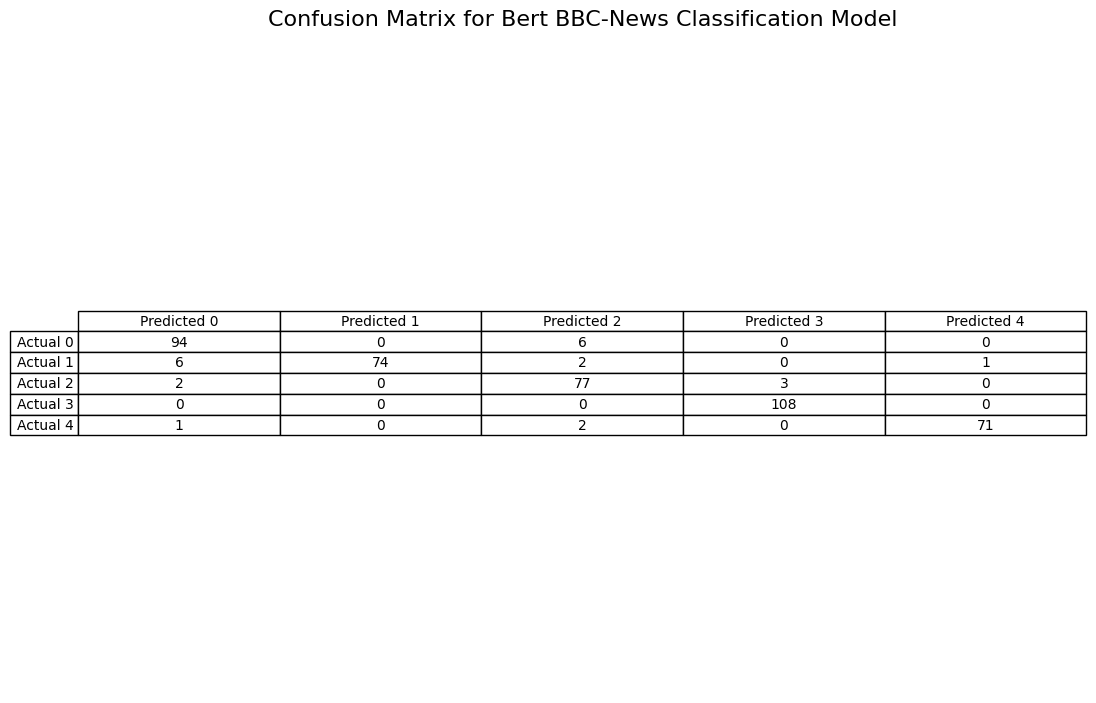

Confusion matrix saved as ../../out/bbc_news_bert_confusion_matrix.png


In [53]:
create_confusion_matrix(
            y_test, 
            all_preds, 
            title='Confusion Matrix for Bert BBC-News Classification Model',
            file_name=OUT_DIR+'bbc_news_bert_confusion_matrix.png',
            debug=False
        )